In [1]:
!rm -rf pytorch_utils_1
!git clone https://github.com/rahuldsce/pytorch_utils_1.git

Cloning into 'pytorch_utils_1'...
remote: Enumerating objects: 176, done.
remote: Counting objects: 100% (176/176), done.
remote: Compressing objects: 100% (91/91), done.
remote: Total 176 (delta 104), reused 143 (delta 84), pack-reused 0
Receiving objects: 100% (176/176), 53.53 KiB | 945.00 KiB/s, done.
Resolving deltas: 100% (104/104), done.


In [2]:
!rm -rf pytorch_utils
!git clone https://github.com/rahuldsce/pytorch_utils.git

Cloning into 'pytorch_utils'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (108/108), done.
remote: Total 111 (delta 56), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (111/111), 38.85 KiB | 698.00 KiB/s, done.
Resolving deltas: 100% (56/56), done.


In [3]:
from pytorch_utils_1 import dataset
train, test = dataset.cifar10_s10_albumentations()

Data has apparently already been downloaded and unpacked.
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_1
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_2
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_3
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_4
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/data_batch_5
Loading data: /tmp/cifar-10-data/cifar-10-batches-py/test_batch


In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from torchsummary import summary


In [5]:
import torch.nn as nn
import torch.nn.functional as F

In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=2, pin_memory=True) if cuda else dict(shuffle=True, batch_size=512)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [7]:
from pytorch_utils import model

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
cifar10_model = model.CIFAR10_S10_RES_NET().to(device)
summary(cifar10_model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,

In [8]:
#parameters
optimizer = torch.optim.Adam(cifar10_model.parameters())
criterion = nn.CrossEntropyLoss()
EPOCHS = 25
MAX_AT_EACH_EPOCH = 5

In [9]:
!pip install pytorch-ignite
from ignite.handlers import FastaiLRFinder
from ignite.engine import create_supervised_trainer

In [10]:
lr_finder = FastaiLRFinder()
to_save = {"model": cifar10_model, "optimizer": optimizer}
with lr_finder.attach(create_supervised_trainer(cifar10_model, optimizer, criterion, device), to_save, end_lr=1.0) as trainer_with_lr_finder:
    trainer_with_lr_finder.run(train_loader)

/usr/local/lib/python3.10/dist-packages/ignite/handlers/lr_finder.py:201: UserWarning: Run completed without loss diverging, increase end_lr, decrease diverge_th or look at lr_finder.plot()
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/ignite/handlers/lr_finder.py:293: UserWarning: skip_start is larger than the suggested LR found and it will not be visible on the plot. Please, make the value smaller.
  warnings.warn(


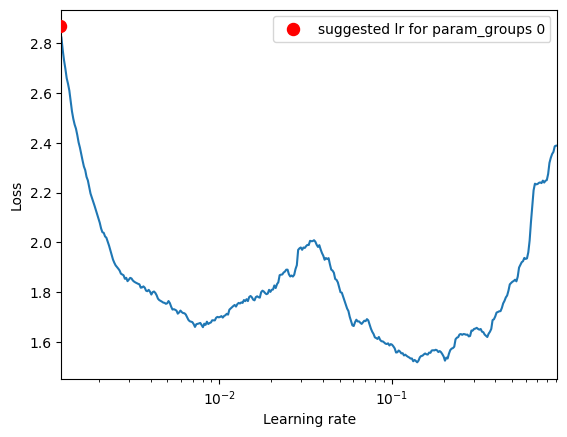

Suggested LR 0.0011932359866287762


In [11]:
lr_finder.plot()
print("Suggested LR", lr_finder.lr_suggestion())
max_lr=lr_finder.lr_suggestion()

In [ ]:
# lr_finder.apply_suggested_lr(optimizer)
# print(optimizer.param_groups[0]["lr"])

6.982159568077148e-06


In [12]:
from pytorch_utils import train, test
import torch.optim as optim
import torch.nn as nn

scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=max_lr, total_steps=EPOCHS, epochs=MAX_AT_EACH_EPOCH,
                       pct_start=0.3, anneal_strategy='linear', div_factor=10, final_div_factor=10)


for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train.train(cifar10_model, device, train_loader, optimizer, criterion)
    test.test(cifar10_model, device, test_loader)
    scheduler.step()


EPOCH: 0


Loss=0.9452397227287292 Batch_id=390 Accuracy=49.59: 100%|██████████| 391/391 [00:19<00:00, 20.53it/s]



Test set: Average loss: 0.0097, Accuracy: 2816/5000 (56.32%)

EPOCH: 1


Loss=0.7006517648696899 Batch_id=390 Accuracy=67.38: 100%|██████████| 391/391 [00:19<00:00, 20.32it/s]



Test set: Average loss: 0.0062, Accuracy: 3624/5000 (72.48%)

EPOCH: 2


Loss=0.6403121948242188 Batch_id=390 Accuracy=75.08: 100%|██████████| 391/391 [00:19<00:00, 20.15it/s]



Test set: Average loss: 0.0057, Accuracy: 3786/5000 (75.72%)

EPOCH: 3


Loss=0.5077583193778992 Batch_id=390 Accuracy=79.29: 100%|██████████| 391/391 [00:19<00:00, 20.28it/s]



Test set: Average loss: 0.0040, Accuracy: 4112/5000 (82.24%)

EPOCH: 4


Loss=0.4679795801639557 Batch_id=390 Accuracy=81.46: 100%|██████████| 391/391 [00:19<00:00, 20.33it/s]



Test set: Average loss: 0.0042, Accuracy: 4081/5000 (81.62%)

EPOCH: 5


Loss=0.3307928442955017 Batch_id=390 Accuracy=83.37: 100%|██████████| 391/391 [00:19<00:00, 20.27it/s]



Test set: Average loss: 0.0039, Accuracy: 4146/5000 (82.92%)

EPOCH: 6


Loss=0.3868081271648407 Batch_id=390 Accuracy=84.77: 100%|██████████| 391/391 [00:19<00:00, 20.23it/s]



Test set: Average loss: 0.0040, Accuracy: 4143/5000 (82.86%)

EPOCH: 7


Loss=0.47569766640663147 Batch_id=390 Accuracy=86.31: 100%|██████████| 391/391 [00:19<00:00, 20.25it/s]



Test set: Average loss: 0.0034, Accuracy: 4296/5000 (85.92%)

EPOCH: 8


Loss=0.4098048806190491 Batch_id=390 Accuracy=88.24: 100%|██████████| 391/391 [00:19<00:00, 20.27it/s]



Test set: Average loss: 0.0038, Accuracy: 4220/5000 (84.40%)

EPOCH: 9


Loss=0.2488660365343094 Batch_id=390 Accuracy=89.58: 100%|██████████| 391/391 [00:19<00:00, 20.31it/s]



Test set: Average loss: 0.0026, Accuracy: 4432/5000 (88.64%)

EPOCH: 10


Loss=0.43302685022354126 Batch_id=390 Accuracy=90.68: 100%|██████████| 391/391 [00:19<00:00, 20.31it/s]



Test set: Average loss: 0.0031, Accuracy: 4371/5000 (87.42%)

EPOCH: 11


Loss=0.21111471951007843 Batch_id=390 Accuracy=91.41: 100%|██████████| 391/391 [00:19<00:00, 20.30it/s]



Test set: Average loss: 0.0026, Accuracy: 4462/5000 (89.24%)

EPOCH: 12


Loss=0.21212442219257355 Batch_id=390 Accuracy=92.13: 100%|██████████| 391/391 [00:19<00:00, 20.27it/s]



Test set: Average loss: 0.0026, Accuracy: 4443/5000 (88.86%)

EPOCH: 13


Loss=0.19106638431549072 Batch_id=390 Accuracy=93.02: 100%|██████████| 391/391 [00:19<00:00, 20.27it/s]



Test set: Average loss: 0.0025, Accuracy: 4470/5000 (89.40%)

EPOCH: 14


Loss=0.1644677072763443 Batch_id=390 Accuracy=93.76: 100%|██████████| 391/391 [00:19<00:00, 20.27it/s]



Test set: Average loss: 0.0023, Accuracy: 4519/5000 (90.38%)

EPOCH: 15


Loss=0.16524572670459747 Batch_id=390 Accuracy=94.66: 100%|██████████| 391/391 [00:19<00:00, 20.28it/s]



Test set: Average loss: 0.0024, Accuracy: 4497/5000 (89.94%)

EPOCH: 16


Loss=0.11704976856708527 Batch_id=390 Accuracy=95.18: 100%|██████████| 391/391 [00:19<00:00, 20.23it/s]



Test set: Average loss: 0.0023, Accuracy: 4533/5000 (90.66%)

EPOCH: 17


Loss=0.08949127048254013 Batch_id=390 Accuracy=95.86: 100%|██████████| 391/391 [00:19<00:00, 20.27it/s]



Test set: Average loss: 0.0022, Accuracy: 4553/5000 (91.06%)

EPOCH: 18


Loss=0.10709933191537857 Batch_id=390 Accuracy=96.63: 100%|██████████| 391/391 [00:19<00:00, 20.25it/s]



Test set: Average loss: 0.0025, Accuracy: 4526/5000 (90.52%)

EPOCH: 19


Loss=0.2140863835811615 Batch_id=390 Accuracy=97.20: 100%|██████████| 391/391 [00:19<00:00, 20.23it/s]



Test set: Average loss: 0.0020, Accuracy: 4594/5000 (91.88%)

EPOCH: 20


Loss=0.06399787217378616 Batch_id=390 Accuracy=97.66: 100%|██████████| 391/391 [00:19<00:00, 20.23it/s]



Test set: Average loss: 0.0021, Accuracy: 4598/5000 (91.96%)

EPOCH: 21


Loss=0.15192675590515137 Batch_id=390 Accuracy=98.06: 100%|██████████| 391/391 [00:19<00:00, 20.23it/s]



Test set: Average loss: 0.0021, Accuracy: 4618/5000 (92.36%)

EPOCH: 22


Loss=0.10161814838647842 Batch_id=390 Accuracy=98.44: 100%|██████████| 391/391 [00:19<00:00, 20.27it/s]



Test set: Average loss: 0.0019, Accuracy: 4634/5000 (92.68%)

EPOCH: 23


Loss=0.02897529862821102 Batch_id=390 Accuracy=98.81: 100%|██████████| 391/391 [00:19<00:00, 20.26it/s]



Test set: Average loss: 0.0020, Accuracy: 4640/5000 (92.80%)

EPOCH: 24


Loss=0.03930671140551567 Batch_id=390 Accuracy=99.00: 100%|██████████| 391/391 [00:19<00:00, 20.23it/s]



Test set: Average loss: 0.0019, Accuracy: 4647/5000 (92.94%)

